<h1>Preprocessing downloaded images for Inference</h1>

Prerequisites:
1. Google Drive account with the downloaded images folder
2. Sufficient space to save the preprocessed images

**Input:** A drive Downloaded Sentinel2 GeoTiff images , 11 Bands, 300x300 pixels

**Output:** Preprocessed GeoTiff images, 15 bands, 300x300 pixels

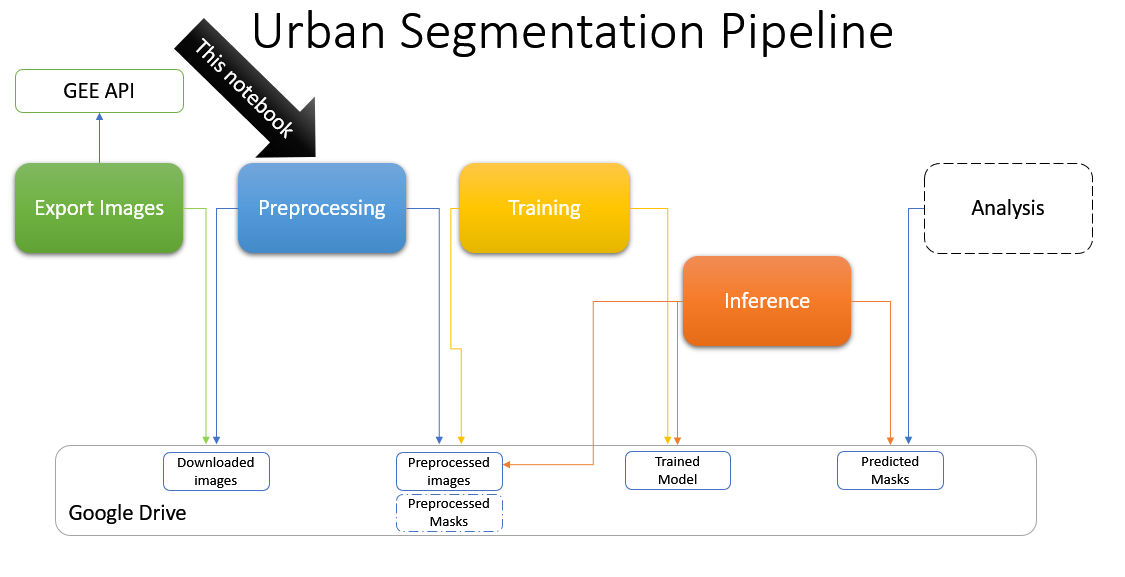

## Running instructions



1.   Connect to the NB
2.   Upload the ssh keys file on "Files" left side panel
3.   Update the downloaded images **input path** in "EXPORT_DIR" in the next cell
4.   Run the notebook to preprocess images and masks

In [ ]:
VERBOSE=True
# Create a path to the exported folder where the ESM and S2 directories were extracted to
#TODO >>>>>>>>>> CHANGE TO THE DOWNLOADED IMAGES DIRECTORY (INPUT)
EXPORT_DIR='/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/'


## Setup

Upload the Git credentials files on the left files panel (if using a secured)Git repo

Alternatively you can download the [Urban Segmentation Git](https://github.com/lleviraz/urban_segmentation) Repo as ZIP file, then upload and extract here 

In [ ]:
#Try cloning first from the public repo
!git clone https://github.com/lleviraz/urban_segmentation.git

In [ ]:
import os
if(not os.path.exists('urban_segmentation')):
  if(os.path.exists('/root/.ssh')):
    !mv -f /root/.ssh /root/.ssh_old
  !unzip gitssh.zip && mv .ssh /root/ && chmod -R 400 /root/.ssh && ls /root/.ssh
  !git clone git@github.com:lleviraz/urban_segmentation.git

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio fastai -q

In [ ]:
import sys
import glob
import numpy as np
import pprint as pp
import pandas as pd
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

## Source folder with the downloaded images

A new target folder will be created with the same location and name and suffix **"_prep"**
All the preprocessed images will be placed there

In [ ]:
#Current working directory
#TODO >>>>>>>>>> IF NEEDED CHANGE TO THE CURRENT WORKING DIRECTORY OF THE NOTEBOOK
WORK_DIR = 'urban_segmentation/'
NB_DIR = WORK_DIR + 'notebooks/'
TARGET_DIR=EXPORT_DIR+'_preproc'
META_DIR = EXPORT_DIR + '_metadata/'

# This directory is the parent of the "libs" directory which is imported below
sys.path.append(NB_DIR)

S2_DIR = EXPORT_DIR
s2_path = Path(S2_DIR)


#our common utils modules
from libs.common import *
from libs.bands import *

path1 = Path(EXPORT_DIR)
three_files = [f for f in path1.iterdir()][:3]
pprint(three_files)
print('Number of input images:',len(glob.glob(S2_DIR + '/*.tif')))

[PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_1.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_2.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_3.tif')]
Number of input images: 49


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


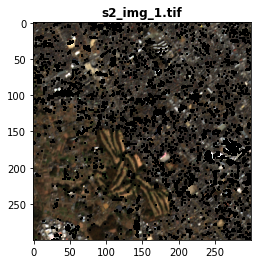

s2_img_1.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.379094069612522, 0.0, 15533706.569938207,
       0.0, -12.433727354093765, 4300933.988254617)}
s2_img_1.tif Transform:
 | 12.38, 0.00, 15533706.57|
| 0.00,-12.43, 4300933.99|
| 0.00, 0.00, 1.00|


In [ ]:
SAMPLE_IMAGE = three_files[0]
if(VERBOSE):
  s2_sample = display_image(SAMPLE_IMAGE,title=SAMPLE_IMAGE.name)
  print_image_metadata(s2_sample,SAMPLE_IMAGE.name)

In [ ]:
NUM_BANDS = 15

bands_dictionary = {
    1:'B1_Blue',
    2:'B2_Green',
    3:'B3_Red',
    4:'B4_Red_Edge_1',
    5:'B5_Red_Edge_2',
    6:'B6_Red_Edge_3',
    7:'B7_NIR',
    8:'B8_Red_Edge_4',
    9:'B9_Water_vapor',
    10:'B10_SWIR_1',
    11:'B11_SWIR_2',
    12:'B12_NDVI', #added in this NB
    13:'B13_NDTI', #added in this NB
    14:'B14_NDVIre', #added in this NB
    15:'B15_MNDWI' #added in this NB
}

## In case the source images names have spaces you can use this to replace it with "_"

In [ ]:
#UNCOMMENT to rename
# rename_images(S2_DIR)

In [ ]:
#UNCOMMENT if you want to regenerate all images
# !rm -rf {TARGET_DIR}

## Resizing to 300x300 + adding 4 new bands to the target images

The target folder will be used in the Inference notebook as input

In [ ]:
batch_resize(S2_DIR,TARGET_DIR,n_bands=NUM_BANDS)

Source dir: /content/drive/MyDrive/gee_export_Jul_14_2022_1601test/
Target dir: /content/drive/MyDrive/gee_export_Jul_14_2022_1601test/_preproc
Creating  /content/drive/MyDrive/gee_export_Jul_14_2022_1601test/_preproc
49 images to resize + additional 4 band to  (15, 300, 300)


  0%|          | 0/49 [00:00<?, ?it/s]

## Calculating new images per band statistics

In [ ]:
stats_mean_df = pd.DataFrame(columns=range(1,NUM_BANDS))
stats_std_df = pd.DataFrame(columns=range(1,NUM_BANDS))

s2_images = glob.glob(TARGET_DIR+ '/*.tif')
for row,image in tqdm(enumerate(s2_images),total=len(s2_images)):
  with rio.open(image,'r') as im:
    for c in range(1,im.count+1):
      chn=np.array(im.read(c))
      #imputing mean and STD of  exported images with the mean and STD of the other non nans values in the channel
      if(np.isnan(chn).sum()>0):
        not_nan =(np.isnan(chn)==False)
        stats_mean_df.loc[row,c] =  chn[not_nan].mean()
        stats_std_df.loc[row,c] = chn[not_nan].std()
        # print(np.isnan(chn).sum())
      else:
        stats_mean_df.loc[row,c] = chn.mean()
        stats_std_df.loc[row,c] = chn.std()
       


  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
cp = stats_mean_df.dropna()

len(stats_mean_df),len(cp)

(49, 49)

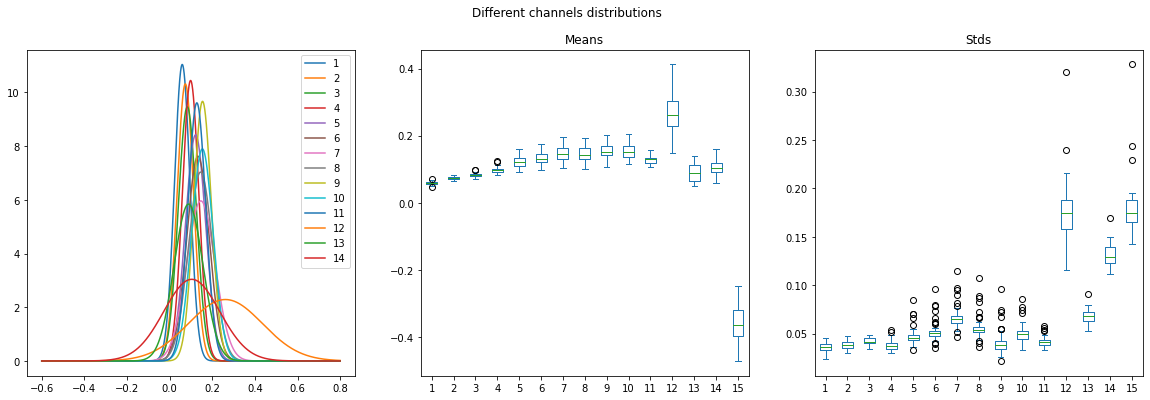

In [ ]:
if(VERBOSE):
  f,axs = plt.subplots(1,3,figsize=(20,6))
  x = np.arange(-0.6, 0.8, 1e-04)
  for i in range(1,NUM_BANDS):
    #Filter some bands
    # if i in [11,12,13,14,15,16]:
    axs[0].plot(x, scipy.stats.norm.pdf(x, stats_mean_df.mean()[i], stats_std_df.mean()[i]),label=i)
      

  stats_mean_df.plot.box(ax=axs[1])
  # stats_mean_df[[12,13,14,15]].plot.box(ax=axs[1])
  axs[1].set_title('Means')
  stats_std_df.plot.box(ax=axs[2])
  # stats_std_df[[12,13,14,15]].plot.box(ax=axs[2])
  axs[2].set_title('Stds')
  axs[0].legend()
  plt.suptitle('Different channels distributions')
  plt.show()

Original training stats


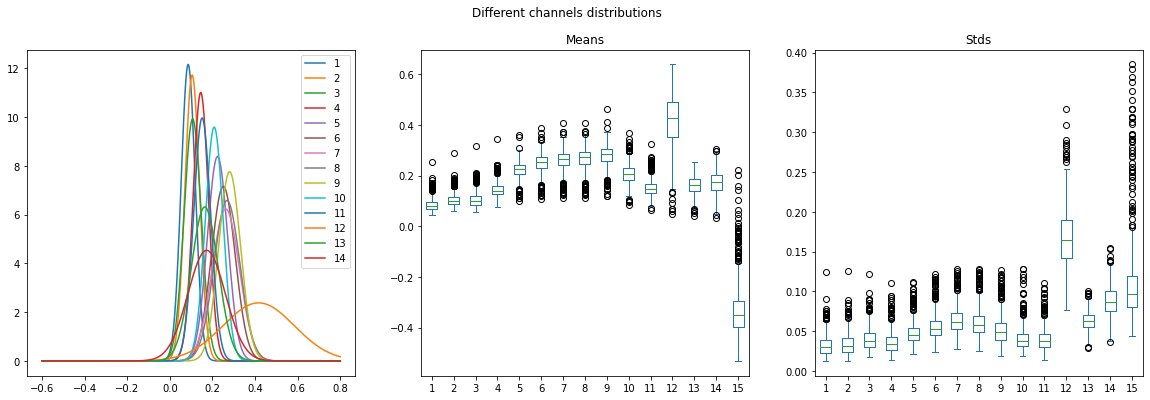

In [ ]:
!mkdir -p {META_DIR}
stats_mean_df.to_csv(META_DIR + 'down_stats_mean_df.csv',header=True)
stats_std_df.to_csv(META_DIR + 'down_stats_std_df.csv',header=True)